In [1]:
"""
Given data sample from unknown distribution or mixture, find best approximation with another distribution/mixture,
estimate posterior distribution of parameters of proposed distribution/mixture given data sample, 
estimate distance between true and estimated distribution.
Class based approach, mixture can be created from distribution objects from scipy.stats module (or np.random for sample generation).
"""

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

from functools import partial

import scipy.stats as st

import copy
import itertools

from sklearn.neighbors import KernelDensity

import warnings

In [3]:
warnings.simplefilter("ignore")

In [4]:
#Here I start with unknown mixture distribution. The task is to approsimate it's parameters with MCMC algorythm
#And to approximate distribution of parameters

In [5]:
#First I create generator. Here i expect to get 1-dimentional data from a mixture on some number of distributions

In [6]:
class CustomMixture():
    """
    Create custom mixture distribution, sample from it, approximate it's pdf and cdf.
    self.mixture is a pandas dataframe and can be used as such.
    """
    def __init__(self):
        self.mixture = pd.DataFrame(columns=['Name','Function','Weights','Normalized'])
       
    def add_new(self, func, f_weight, name=None, *args, **kwargs):
        """
        Pass *args, **kwargs along with the function. Do NOT pass size of the desired output, as it's expected to be a scalar.
        Weights are normalized and used as multinomial parameter for sampling.
        Providing meaningful names is strongly advised.
        """
        assert f_weight >0, "Weight should be positive"
        new_entry = pd.DataFrame({
                                    'Name':name, 
                                    'Function':partial(func,*args, **kwargs), 
                                    'Weights':f_weight, 
                                    'Normalized':f_weight
                                },
                                index=[0])
        self.mixture = self.mixture.append(new_entry, ignore_index=True)
        self.mixture['Normalized'] = self.mixture['Weights']/np.sum(self.mixture['Weights'])
     
    def sample(self, n=100):
        x = np.zeros([n])
        for i in range(n):
            x[i]=self.mixture['Function'][np.flatnonzero(np.random.multinomial(1,self.mixture['Normalized']))[0]]()
        return x

    def approximate_pdf(self, n=10000):
        x = self.sample(n)
        x_25, x_75 = np.quantile(x,[0.25, 0.75])
        iqr = np.abs(x_75-x_25)
        h = 2*iqr*n**(-1/3)
        n_bins = np.round(np.abs(np.max(x)-np.min(x))/h).astype(int)
        plt.hist(x, bins=n_bins, density=True)
    
    def approximate_cdf(self, n=10000):
        x = self.sample(n)
        quantiles = np.linspace(0,1,200)
        values = np.quantile(x,np.linspace(0,1,200))
        plt.plot(values, quantiles)
        
    def view(self):
        print("Custom mixture class:")
        print(self.mixture)
        
    def __repr__(self):
        return str("Custom mixture class:"\
                  f'{self.mixture.head(-1)}')

In [7]:
my_mix = CustomMixture()

In [8]:
#I'll go with a combination of 2 gaussians with parameters(0,1), (4,2) and a uniform on [0,2]. 
#I'll set weights to [0.5, 0.3, 0.2].

In [9]:
my_mix.add_new(func = np.random.normal, f_weight = 4, name = "Normal (0,1)", loc=0, scale=1)
my_mix.add_new(func = np.random.normal, f_weight = 4, name = "Normal(4,2)", loc=5, scale=2)
my_mix.add_new(func = np.random.uniform, f_weight = 2, name = "Uniform on [0,2)", low=0, high=2)

In [10]:
my_mix.mixture

,Name,Function,Weights,Normalized
0,"Normal (0,1)",functools.partial(<built-in method normal of n...,4,0.4
1,"Normal(4,2)",functools.partial(<built-in method normal of n...,4,0.4
2,"Uniform on [0,2)",functools.partial(<built-in method uniform of ...,2,0.2


In [11]:
data = my_mix.sample(n=10000)

In [12]:
#Task is to find best approximation of a target distribution over parameter space of a given mixture.

In [13]:
class ProbModel(CustomMixture):
    """
    Create mixture of distributions. Parameters of these distributions and their weights are learned from data.
    """
    def __init__(self, data=None):
        """
        Data can be assigned on creation or later.
        """
        self.mixture = pd.DataFrame(columns=['Name','Distribution','Parameters','Weights','Normalized'])
        self.mixture.set_index('Name', inplace=True)
        self.is_fit = False
        self.data = data
        self.history = "No history"
        
    def convert_dict(self, val_in=None, to_dict=False):
        """
        Pandas has trouble storing dictionaries in DF cells. 
        Thus, one solution is to convert a dictionary into string and vice versa. 
        'to_dict=False' converts dict to string, 'True' does the opposite
        """
        
        if to_dict == False:
            val_out = ''
            for key, value in val_in.items():
                val_out = ' '.join([str(val_out), str(key), str(value)])        
        elif to_dict == True:
            list_form = val_in.split()
            val_out = {}
            keys = list_form[::2]
            values = list_form[1::2]
            assert len(keys) == len(values), 'Keys and vals are of different lenght at "covert_to_dict method".'
            for i in range(len(keys)):
                val_out[keys[i]] = float(values[i])
        else:
            raise ValueError("'to_dict' must be a boolean.")
        return val_out
        
    def add_new(self, dist, dist_weight=1, name=None, kwargs=None):
        """
        'dist' must be scipy.stats class corresponding to desired distribution in mixture
        Do NOT pass size of the desired output, as it's expected to be a scalar.
        Parameters are passed as dictionary in 'kwargs' 
        Weights are normalized.
        Providing meaningful names is strongly advised.
        Mixture is optimized over passed parameters, thus, all relevant values must be passed as kwargs.
        """
        assert dist_weight >0, "Weight should be positive"
        new_entry = pd.DataFrame({
                                    'Name':name, 
                                    'Distribution':dist, 
                                    'Parameters':self.convert_dict(kwargs),
                                    'Weights':dist_weight, 
                                    'Normalized':dist_weight
                                },
                                index=[0])
        new_entry.set_index('Name', inplace=True)
        self.mixture = self.mixture.append(new_entry)
        self.mixture['Normalized'] = self.mixture['Weights']/np.sum(self.mixture['Weights'])
        
    def calc_likelihood(self, params, new_params, data):
        
        """
        Calculate likelihood of each data point in a batch for each distribution and set of parameters
        """
        #get current and proposed parameters

        #calculate likelihood for current and proposed distributions        
        # c_lh -> current likelihood
        # p_lh -> proposed likelohood
        index = pd.MultiIndex.from_product([list(self.mixture.index),['c_lh','p_lh']], 
                                           names=['distribution', 'prior/posterior'])
        self.likelihood = pd.DataFrame(columns=index, index = range(len(data)))
        for name in list(self.mixture.index):
            self.likelihood[name,'c_lh'] = self.mixture['Distribution'][name].logpdf(data,**params[name])
            self.likelihood[name,'p_lh'] = self.mixture['Distribution'][name].logpdf(data,**new_params[name]) 
    
    def create_permutations(self):
        columns_list = list(self.likelihood.columns.values)
        chunks = [columns_list[x:x+2] for x in range(0, len(columns_list), 2)]
        self.permutations = itertools.product(*chunks)
        #print(list(self.permutations))
    
    def decide_update(self, data, step_scale=1, strict=True):
        """
        Calculate whether parameters are updated at each step. 
        Parameters are updated separately to the best combination of current/updated parameters.
        """
        params = {name:self.convert_dict(self.mixture['Parameters'][name],to_dict=True) for name in self.mixture.index}
        new_params = copy.deepcopy(params)
        for index_i in new_params.keys():
            for index_j in new_params[index_i].keys():
                new_params[index_i][index_j] += np.random.normal(scale=step_scale)
        self.calc_likelihood(params, new_params, data)
        current_likelihood = self.likelihood.loc[:,pd.IndexSlice[:,'c_lh']].max(axis=1).sum(axis=0)
        #Check for nan values. On encounter, parameters are rejected and drawn anew
        if np.isnan(np.sum(self.likelihood.values)):
            #draw new parameters for batch untill valid parameter combination is drawn
            self.decide_update(data)
        else:
            if strict:
                proposed_likelihood = self.likelihood.loc[:,pd.IndexSlice[:,'p_lh']].max(axis=1).sum(axis=0)
                p_change = np.exp(1)**(proposed_likelihood-current_likelihood)
                if p_change > 1:
                    self.best_params = new_params
                if np.random.rand(1) < p_change:
                    params_to_pass = new_params
                else:
                    params_to_pass = params
                for dist in params_to_pass.keys():
                    params_to_pass[dist] = self.convert_dict(val_in=params_to_pass[dist])

                params_to_pass = pd.DataFrame.from_dict(params_to_pass, orient='index')
                self.mixture['Parameters'] = params_to_pass[:][0]
            else:
                #best combination of current/proposed parameters is proposed for update
                proposed_likelihood = -99999
                #list of labels [(distribution, c_lh/p_lh)]
                update = list(self.likelihood.loc[:,pd.IndexSlice[:,'c_lh']].columns.values)
                self.create_permutations()
                for permutation in list(self.permutations)[1:]:
                    likelihood = self.likelihood[list(permutation)].max(axis=1).sum(axis=0)
                    if likelihood > proposed_likelihood:
                        proposed_likelihood = likelihood
                        update = list(permutation)
                #prior distribution of parameter is considered uniform, thus, update only relies on likelihood
                p_change = np.exp(1)**(proposed_likelihood-current_likelihood)
                if p_change > 1:
                    self.best_params = new_params
                params_to_pass = {}
                if np.random.rand(1) < p_change:
                    #update
                    for dist in update:
                        if dist[1] == 'p_lh':
                            params_to_pass[dist[0]]=new_params[dist[0]]
                        elif dist[1] == 'c_lh':
                            params_to_pass[dist[0]]=params[dist[0]]
                        else:
                            raise ValueError("Likelihood is neither current 'c_lh', nor proposed 'p_lh'.")
                else:
                    params_to_pass = params
                for dist in params_to_pass.keys():
                    params_to_pass[dist] = self.convert_dict(val_in=params_to_pass[dist])

                params_to_pass = pd.DataFrame.from_dict(params_to_pass, orient='index')
                self.mixture['Parameters'] = params_to_pass[:][0]
    
    def fit(self, epochs=1, step_scale=1, strict=True):
        """
        burn-in not specified, slice history object instead
        use 'strict'=True for joint posterior of parameter and 'strict=False' for faster convergence
        """
        #have to use batches or likelihood becomes to low for machine to calculate
        #batches of size 100 seem to work consistently
        #create/clean history, write best parameters
        params = {name:self.convert_dict(self.mixture['Parameters'][name],to_dict=True) for name in self.mixture.index}
        self.best_params = params 
        self.history = pd.DataFrame(pd.DataFrame(params).unstack()).transpose()

        #get sample of params distribution
        for i in range(epochs):
            for i in range(len(self.data//100)):
                data = np.random.choice(self.data, size=100, replace=False)
                self.decide_update(data, step_scale, strict)
                #write to history
                params = {name:self.convert_dict(self.mixture['Parameters'][name],to_dict=True) for name in self.mixture.index}
                self.history = self.history.append(pd.DataFrame(pd.DataFrame(params).unstack()).transpose(), ignore_index=True)
        
        #plug-in best estimate
        self.best_params = pd.DataFrame.from_dict(self.best_params, orient='index')
        self.mixture['Parameters'] = self.best_params[:][0]
        
        self.get_weights()        
        
        self.is_fit = True
    
    def get_weights(self):
        for name in self.mixture.index:
            self.mixture.loc[name]['Weights'] = self.mixture.loc[name]['Distribution'].pdf(self.data,
                                                                **self.convert_dict(self.mixture.loc[name]['Parameters'], 
                                                        to_dict=True)).sum()
        self.mixture['Normalized'] = self.mixture['Weights']/np.sum(self.mixture['Weights'])
        
    def sample(self, n=10000):
        x = np.zeros([n])
        for i in range(n):
            mul = np.flatnonzero(np.random.multinomial(1,self.mixture['Normalized']))[0]
            x[i]=self.mixture['Distribution'][mul].rvs(**self.convert_dict(self.mixture['Parameters'][mul],to_dict=True))
        return x        
    
    def get_distance(self, n=10000, visual=True):
        """
        Estimate max distance between cdf for data and for supposed distribution mixture. 
        """
        #plot
        if visual:
            x = self.sample(n)
            quantiles = np.linspace(0,1,200)
            x_quantiles = np.quantile(x,np.linspace(0,1,200))
            y_quantiles = np.quantile(self.data ,np.linspace(0,1,200))
            plt.plot(x_quantiles, quantiles)
            plt.plot(y_quantiles, quantiles)
            plt.legend(['Data','Approximation'])
            plt.show()
        
        #distance
        #have value for x. need cdf(x) in both dists
        q_range = np.linspace(np.min(self.data), np.max(self.data),1000)
        self.distances = np.zeros(1000)
        for i in range(len(self.distances)):
            self.distances[i] = np.abs(np.sum(x<q_range[i])/len(x) - np.sum(self.data<q_range[i])/len(self.data))
        if visual:
            print('Max distance: ',round(np.max(self.distances),4),' at x=',round(q_range[np.argmax(self.distances)],4))
        return np.max(self.distances)

In [14]:
new_class = ProbModel(data)
new_class.add_new(st.norm, dist_weight=1, name="Normal 1",kwargs = {'loc':0,'scale':1})
new_class.add_new(st.norm, dist_weight=1, name="Normal 2",kwargs = {'loc':0,'scale':1})

In [15]:
new_class.fit()
new_class.mixture

,Distribution,Parameters,Weights,Normalized
Name,,,,
Normal 1,<scipy.stats._continuous_distns.norm_gen objec...,loc 4.9019049116917985 scale 1.3925692475994145,701.104927,0.298106
Normal 2,<scipy.stats._continuous_distns.norm_gen objec...,loc 0.3058803248552854 scale 1.130985649019325,1650.761066,0.701894


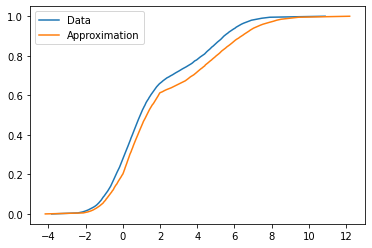

Max distance:  0.0776  at x= 0.0282


0.07759999999999997

In [16]:
new_class.get_distance()

In [17]:
#discard 10% as burn-in
new_class.history[len(new_class.history)//10:].corr()

Normal 1            Normal 2          
                     loc     scale       loc     scale
Normal 1 loc    1.000000 -0.223726  0.027745  0.153789
         scale -0.223726  1.000000 -0.176725 -0.094243
Normal 2 loc    0.027745 -0.176725  1.000000  0.021966
         scale  0.153789 -0.094243  0.021966  1.000000

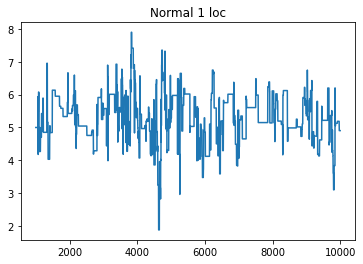

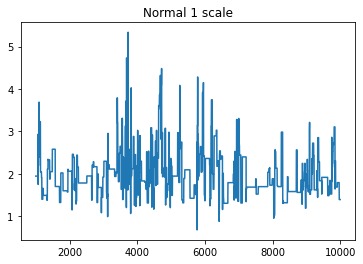

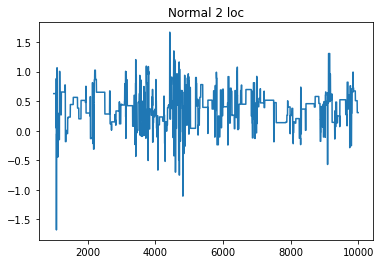

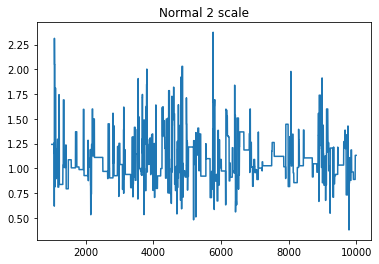

In [18]:
#trace graphs
for column in new_class.history.columns:
    fig, ax = plt.subplots()
    plt.plot(new_class.history[column][len(new_class.history)//10:])
    ax.set_title(' '.join(list(column)))
    plt.show()

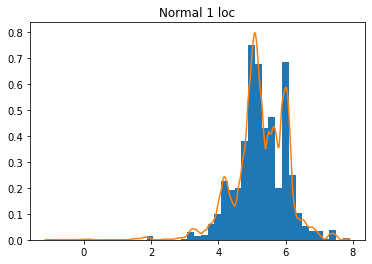

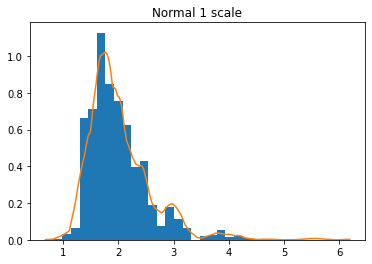

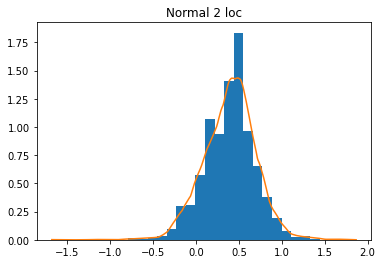

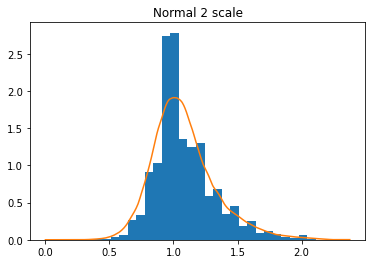

In [19]:
for column in new_class.history.columns:
    fig, ax = plt.subplots()
    plt.hist(new_class.history[column][len(new_class.history)//10:], bins=30, density=True)
    ax.set_title(' '.join(list(column)))
    
    linspace = np.linspace(np.min(new_class.history[column]), np.max(new_class.history[column]),1000)[:, np.newaxis]
    
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.2).fit(new_class.history[column][:, np.newaxis])
    log_dens = kde.score_samples(linspace)
    ax.plot(linspace, np.exp(log_dens), linestyle='-', label="epanechnikov")
    
    plt.show()